In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [27]:
#'''
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
'''
path_to_file = 'kor-eng/kor.txt'
'''

"\npath_to_file = 'kor-eng/kor.txt'\n"

In [28]:
# import pandas as pd
# pd.read_csv(path_to_file, sep='\t', header=None)[[0,1]].to_csv(path_to_file, sep='\t', header=None, index=False)

In [29]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    #w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", w)
    
    w = w.strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [30]:
en_sentence = u"May I borrow this book?"
kor_sentence = u"이 책 좀 빌릴 수 있을까?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(kor_sentence).encode('utf-8'))
print(preprocess_sentence(kor_sentence))

<start> May I borrow this book ? <end>
b'<start> \xec\x9d\xb4 \xec\xb1\x85 \xec\xa2\x80 \xeb\xb9\x8c\xeb\xa6\xb4 \xec\x88\x98 \xec\x9e\x88\xec\x9d\x84\xea\xb9\x8c ? <end>'
<start> 이 책 좀 빌릴 수 있을까 ? <end>


In [31]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [32]:
en, kor = create_dataset(path_to_file, None)
print(en[-1])
print(kor[-1])

<start> If you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> Si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un m sico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [33]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [34]:
def load_dataset(path, num_examples = None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [35]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [36]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [37]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [38]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> ¿
97 ----> ten
13 ----> s
1053 ----> dudas
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
22 ----> do
6 ----> you
29 ----> have
1117 ----> doubts
7 ----> ?
2 ----> <end>


In [39]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [40]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 11]))

In [41]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [42]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [43]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        #query hidden state shape == (batch_size, hidden size)
        #query_with_time_axis_shape == (batch_size, 1, hidden size)
        #values shape == (batch_size, max_len, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        
        #attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [44]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [45]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        #used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        #enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        #x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        #x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        #passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        #output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output shape == (batch+size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights

In [46]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4934)


In [47]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, 
                                encoder = encoder,
                                decoder = decoder)

### Training Strategy
<ol>
    <li>Pass the input through the encoder which return encoder output and the encoder hidden state.</li>
    <li>The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.</li>
    <li>The decoder returns the predictions and the decoder hidden state.</li>
    <li>The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.</li>
    <li>Use teacher forcing to decide the next input to the decoder.</li>
    <li>Teacher forcing is the technique where the target word is passed as the next input to the decoder.</li>
    <li>The final step is to calculate the gradients and apply it to the optimizer and backpropagate.</li>
</ol>

In [49]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [50]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6745
Epoch 1 Batch 100 Loss 2.1961
Epoch 1 Batch 200 Loss 2.0082
Epoch 1 Batch 300 Loss 1.7722
Epoch 1 Loss 2.0721
Time taken for 1 epoch 93.32070255279541 sec

Epoch 2 Batch 0 Loss 1.6803
Epoch 2 Batch 100 Loss 1.6360
Epoch 2 Batch 200 Loss 1.5496
Epoch 2 Batch 300 Loss 1.3447
Epoch 2 Loss 1.4952
Time taken for 1 epoch 72.6403112411499 sec

Epoch 3 Batch 0 Loss 1.2324
Epoch 3 Batch 100 Loss 1.2286
Epoch 3 Batch 200 Loss 1.1299
Epoch 3 Batch 300 Loss 0.9894
Epoch 3 Loss 1.1245
Time taken for 1 epoch 70.88514614105225 sec

Epoch 4 Batch 0 Loss 0.8207
Epoch 4 Batch 100 Loss 0.8613
Epoch 4 Batch 200 Loss 0.7960
Epoch 4 Batch 300 Loss 0.7725
Epoch 4 Loss 0.8127
Time taken for 1 epoch 72.18241596221924 sec

Epoch 5 Batch 0 Loss 0.6535
Epoch 5 Batch 100 Loss 0.6005
Epoch 5 Batch 200 Loss 0.5151
Epoch 5 Batch 300 Loss 0.5545
Epoch 5 Loss 0.5755
Time taken for 1 epoch 59.512595891952515 sec

Epoch 6 Batch 0 Loss 0.3286
Epoch 6 Batch 100 Loss 0.3862
Epoch 6 Batch 200 Loss

### Translate
<ul>
    <li>The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.</li>
    <li>Stop predicting when the model predicts the end token.</li>
    <li>And store the attention weights for every time step.</li>
</ul>

In [51]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen = max_length_inp,
                                                          padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        
        #storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [52]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [53]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
#translate(u'여기 매우 춥다')

In [56]:
#translate(u'여기가 내 삶이야')

In [57]:
#translate(u'아직 집이니?')

In [58]:
#translate(u'한번 시도해봐.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


c:\workspace\python\jupyterenv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\workspace\python\jupyterenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


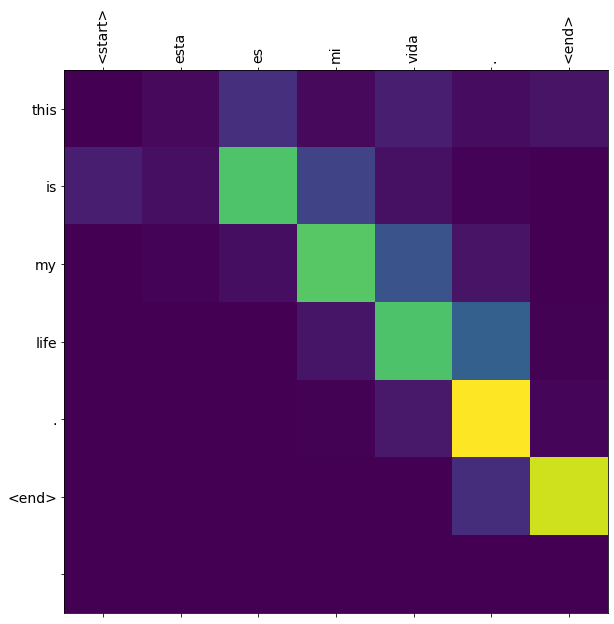

In [59]:
translate(u'esta es mi vida.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


c:\workspace\python\jupyterenv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\workspace\python\jupyterenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


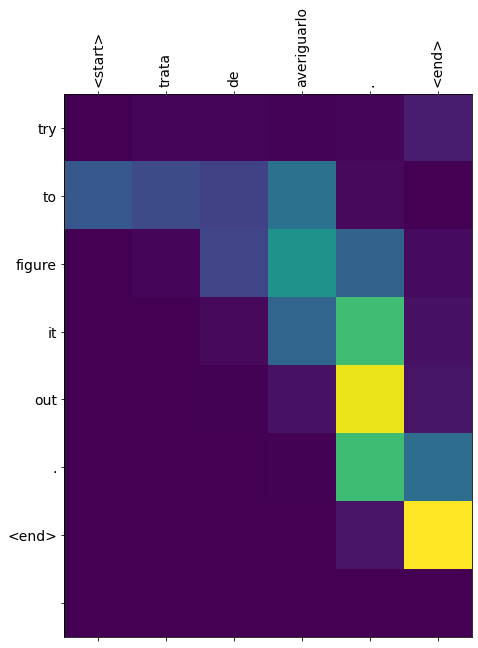

In [60]:
# 잘못된 번역
translate(u'trata de averiguarlo.')